# Analysis Scripts for Transmissivity

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.integrate
import scipy.interpolate

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

## Utility libraries
from netCDF4 import Dataset
import glob

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [2]:
# %% Load files and perform setup

eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, **geom_files)

uph = np.load('./outputs/phase_vel.npz')['u_lstsq']

# Set up zonal interpolation function
tind = 400
ksurf0 = 196
zpot = xgcdata['pot00'][tind,:]
zpot_psi = xgcdata['psi00'][:]
interp_zpot = scipy.interpolate.CubicSpline(zpot_psi, zpot, extrapolate=True)
zonalFields = XgcZonalFieldHandler(eq, xgcdata, tind)

# Set up ballooning mode interpolator
fit_results = np.load('./outputs/fit_results.npz', allow_pickle=True)
params_g, params_gh = fit_results['params_g'], fit_results['params_gh']

# Set up the interpolator
mode = GaussHermiteFunction(params_g[:4], params_gh)
interp_balloon = [(39, mode)]

ballFields = GaussHermiteFieldHandler(geom, interp_zpot, interp_balloon)

tind0 = tind #424, 386

omega_frame = -uph[tind0,ksurf0]*geom.q_surf[ksurf0]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(0, omega_frame, tind0)
t0 = rotating_frame.t0

In [11]:
# %% Load data and compute Poincare sections

pp = particle_motion.deut

filelabel = 'psinn02_r100'
output_dir = 'D:/Documents/IFS/hmode_jet/outputs/'

paths = glob.glob(output_dir+'transmissivity/{}/{}_mu[0-9][0-9].npz'.format(filelabel, filelabel))

num_saves = len(paths)
print('num_saves: {}'.format(num_saves))
ncheckpoint = 800

escape_times = None
initial_conditions = None
nvll = 0
nphi = 0

# TODO: Refactor so we don't load the entire trajectory into memory to compute the punctures
for kmu in range(num_saves):
    with np.load(output_dir + 'transmissivity/{}/{}_mu{:02d}.npz'.format(filelabel, filelabel, kmu)) as data:
        mu_grid = data['mu_grid']
        vll_grid = data['vll_grid']
        varphi_grid = data['varphi_grid']

        if escape_times is None:
            nvll = len(vll_grid)
            nphi = len(varphi_grid)
            escape_times = np.empty((num_saves, nvll, nphi))
            #initial_conditions = np.empty((num_saves, nvll, nphi))

        escape_times[kmu,:,:] = np.reshape(data['escape_times'], (nvll, nphi))
        #initial_conditions[kmu,:,:] = np.reshape(data['initial_conditions'], (nvll, nphi))


# Compute Poincare section
#ppunc, npunc = particle_tools.compute_midplane_punctures(t, y, geom)
#ppunc2, npunc2 = particle_tools.compute_toroidal_punctures(t, y, rotating_frame, period=(2*np.pi/39), offset = (-np.pi/39))


num_saves: 1


In [7]:
escape_times.shape

(1, 32, 32)

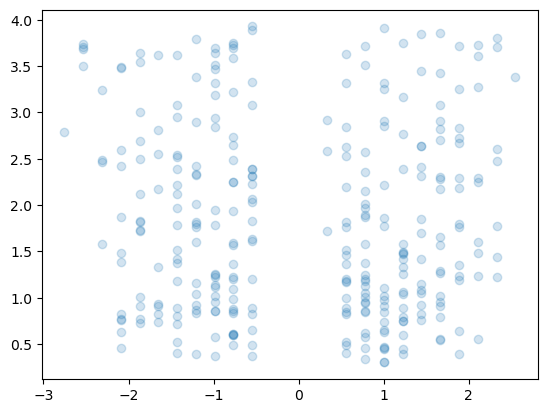

In [ ]:
# %% Distribution of escape times
plt.figure()
vll_data = np.repeat(vll_grid, nphi)

plt.scatter(vll_data/pp.vt, escape_times.flatten(), alpha=0.2)

In [15]:
# %% Transmissivity
transmissivity = np.sum(np.isfinite(escape_times), axis=2)

In [16]:
transmissivity.shape

(1, 32)

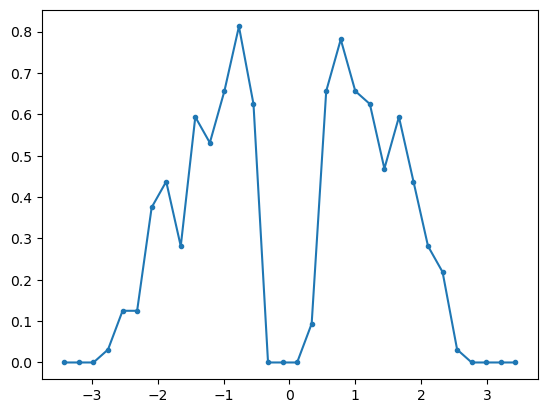

In [19]:
plt.figure()
plt.plot(vll_grid/pp.vt, transmissivity[0,:]/nphi, marker='.')